In [1]:
# Step 1: Import Libraries

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from scipy.spatial import distance
from pathlib import Path
from math import pi

import pickle
import shap

from piecewise import *

In [2]:
# Step 2: Helper functions

def calculate_inertia(predictions, data, centroids):
    dist = 0
    data = data.to_numpy()
    for i in range(len(data)):
        centroid_index = predictions[i]
        dist += distance.euclidean(data[i], centroids[centroid_index])
    return dist


def define_number_of_clusters(z, path):
    inertia_score = []
    sh_score = []
    db_score = []
    bic_score = []
    ch_score = []
    for i in range(2, 11):
        clustering = GaussianMixture(n_components=i, n_init=100, random_state=0, covariance_type="diag").fit(z)
        predictions = clustering.predict(z)

        bic_score.append(clustering.bic(z))
        inertia_score.append(calculate_inertia(predictions, z, clustering.means_))
        sh_score.append(silhouette_score(z, predictions))
        db_score.append(davies_bouldin_score(z, predictions))
        ch_score.append(calinski_harabasz_score(z, predictions))

    inertia_score = np.array(inertia_score)
    inertia_score = inertia_score/max(inertia_score)

    plt.figure()
    plt.plot(list(range(2, 11)), inertia_score, "-*")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Distances (Normalised)")
    plt.xticks(list(range(2, 11)), list(range(2, 11)))
    plt.savefig(os.path.join(path, 'Define Clusters (Inertia Score).svg'))
    plt.savefig(os.path.join(path, 'Define Clusters (Inertia Score).png'))
    plt.show()

    plt.figure()
    plt.plot(list(range(2, 11)), sh_score, "-*")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.xticks(list(range(2, 11)), list(range(2, 11)))
    plt.savefig(os.path.join(path, 'Define Clusters (Silhouette).svg'))
    plt.savefig(os.path.join(path, 'Define Clusters (Silhouette).png'))
    plt.show()

    plt.figure()
    plt.plot(list(range(2, 11)), db_score, "-*")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Davies-Bouldin Score")
    plt.xticks(list(range(2, 11)), list(range(2, 11)))
    plt.savefig(os.path.join(path, 'Define Clusters (Davies-Bouldin).svg'))
    plt.savefig(os.path.join(path, 'Define Clusters (Davies-Bouldin).png'))
    plt.show()

    plt.figure()
    plt.plot(list(range(2, 11)), bic_score, "-*")
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC Score")
    plt.xticks(list(range(2, 11)), list(range(2, 11)))
    plt.savefig(os.path.join(path, 'Define Clusters (BIC).svg'))
    plt.savefig(os.path.join(path, 'Define Clusters (BIC).png'))
    plt.show()

    plt.figure()
    plt.plot(list(range(2, 11)), ch_score, "-*")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Calinski-Harabasz Score")
    plt.xticks(list(range(2, 11)), list(range(2, 11)))
    plt.savefig(os.path.join(path, 'Define Clusters (CH).svg'))
    plt.savefig(os.path.join(path, 'Define Clusters (CH).png'))
    plt.show()


In [4]:
# Step 3: Load the available dataset

# paths could be subjective to changes depending on the project's folder lay-out
parent_folder = os.path.join(*Path(os.getcwd()).parts[:-2], "LV Strain Curves")
data_path = os.path.join(parent_folder, "Data/FLEMENGHO/Strain curves (Filtered)")

# manual annotation of the Aortic Valve Closure
avc_files = ["Data/FLEMENGHO/AVC time_16_all.xlsx", "Data/FLEMENGHO/Patients Without AVC_TK.xlsx"]
# manual annotation of the P-wave in the ECG
marker_file = ["Data/FLEMENGHO/Patients for manual annotation of markers_TK.xlsx"]

original_data, data, patient_id, interval = ld.read_data(data_path)
excluded_patients1, avc_times = ld.read_avc_time(parent_folder, avc_files)
excluded_patients2, p_wave_times = ld.read_p_wave_data(parent_folder, marker_file)

original_data, data, patient_id, interval = exclude_patients(excluded_patients1, excluded_patients2, original_data,
                                                             data, patient_id, interval)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Patient with ID: 23074 is not in dataset
Patient with ID: 23331 is not in dataset
Patient with ID: 931 is not in dataset
Patient with ID: 23074 is not in dataset
Patient with ID: 23331 is not in dataset


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [5]:
# Step 4: Perform temporal alignment

decision = "peak"
reference_patient_id = "1687"

# Align the ECG and the strain curves based on a reference signal.
LV_ecg_aligned, LV_deformation, _, _, LV_reference_time = get_aligned_signals(original_data, decision, interval,
                                                                              patient_id,reference_patient_id, avc_times, p_wave_times)
LV_deformation = np.array(LV_deformation)

Start slicing data
Start Alignment
Start slicing data
Start Alignment


In [10]:
#Step 5a: Extract the LV features
save_data_path = os.path.join(*Path(os.getcwd()).parts[:-2], f"Results/Summary Index/GMM/LV")
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

extracted_features = extract_time_series_features(LV_reference_time, LV_deformation, patient_id, save_data_path, do_plot=False)
training_data = {"peak": extracted_features["Peak"], "peak_slopes": extracted_features[["Systolic Slope", "Diastolic Slope","Peak"]], "all":extracted_features}

100%|██████████| 1207/1207 [08:43<00:00,  2.31it/s]


In [11]:
# Step 5b: Select the desired features. All available features are selected
select_features = "all"
save_data_path = os.path.join(save_data_path, select_features)
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)

In [ ]:
# Step 6: Find the optimal number of clusters
define_number_of_clusters(training_data[select_features], save_data_path)

In [ ]:
# Step 7: Train Gaussian Mixture Model
clustering_model = GaussianMixture(n_components=4, n_init=30, random_state=0, covariance_type="diag").fit(training_data[select_features])
clusters = clustering_model.predict(training_data[select_features])
centres = clustering_model.means_
pickle.dump(clustering_model, open(os.path.join(save_data_path, "gmm_model.pkl"), 'wb'))

In [14]:
# Step 8: Calculate SHAP values
# clustering_model = pickle.load(open(os.path.join(save_data_path,"gmm_model.pkl"), 'rb'))
# clusters = clustering_model.predict(training_data[select_features])
explainer = shap.KernelExplainer(clustering_model.predict_proba, training_data[select_features])
shap_values_bsw = explainer.shap_values(training_data[select_features])

representative_centers = np.array(produce_centroids(clusters, LV_deformation))

X does not have valid feature names, but GaussianMixture was fitted with feature names
Using 1207 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1207 [00:00<?, ?it/s]

X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but GaussianMixture was fitted with feature names
X does not have valid feature names, but Ga

In [16]:
# Step 9: SHAP analysis results
cluster_labels = {0:1, 1:4, 2:2, 3:3}
cluster_colours = {0:"green", 1:"red", 2:"blue", 3:"blueviolet"}
for i in range(len(np.unique(clusters))):
    shap.summary_plot(shap_values=shap_values_bsw[i], features=training_data[select_features], title=f"Cluster {cluster_labels[i]}", show=False)
    ax = plt.gca()
    ax.set_xlim(-0.5, 0.8)
    plt.savefig(os.path.join(save_data_path, f"Shap Cluster {cluster_labels[i]}.svg"))
    plt.savefig(os.path.join(save_data_path, f"Shap Cluster {cluster_labels[i]}.png"))
    plt.close()

C:\Users\vagge\Desktop\PhD\Deformation Curves\Results/Summary Index/GMM/LV\all


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [ ]:
# Step 10: Plot the clustering results

# groups the patients' ids per cluster. Returns a list
clustered_id = analyze_patient(clusters, patient_id.tolist())

# writes an excel file with the patient's ID and its assigned cluster label
write2excel(clusters, patient_id.tolist(), save_data_path, cluster_labels)

# plots the strain traces grouped per cluster with Matplotlib and plotly. Matplotlib produces png and svg files.
visualize_clustering_results(LV_reference_time, LV_deformation, clustered_id, clusters,
                             patient_id.tolist(), representative_centers, save_data_path,
                             cluster_labels=cluster_labels, cluster_colours=cluster_colours)

# plot the first three principal components of the strain curves
plot_pca(clusters, LV_deformation, patient_id.tolist(), save_data_path,
         cluster_labels=cluster_labels, cluster_colours=cluster_colours)

# plots the gradient of the Strain traces with Matplotlib and plotly.
plot_gradients(LV_deformation, LV_reference_time, clusters, clustered_id,
               patient_id.tolist(), save_data_path, cluster_labels=cluster_labels,
               cluster_colours=cluster_colours)

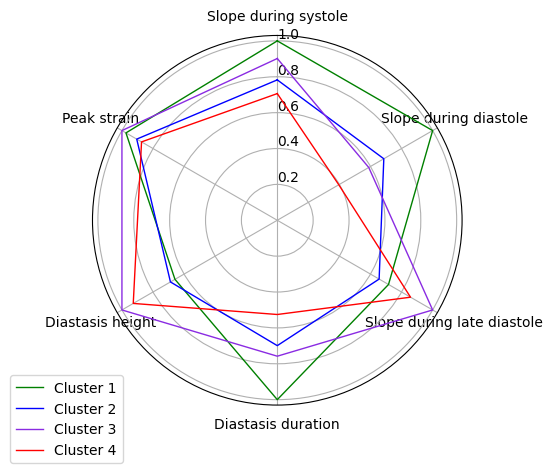

In [40]:
# Step 11: Plot the average values of features by GMM

model = pickle.load(open(os.path.join(save_data_path,"gmm_model.pkl"), 'rb'))
centroids = np.abs(model.means_)
centroids = centroids/ centroids.max(axis=0)

# Set data
df = pd.DataFrame({
'group': ['Cluster 1','Cluster 2','Cluster 3','Cluster 4'],
'Slope during systole': [centroids[3, 0], centroids[2, 0], centroids[0, 0], centroids[1, 0]],
'Slope during diastole': [centroids[3, 1], centroids[2, 1], centroids[0, 1], centroids[1, 1]],
'Slope during late diastole': [centroids[3, 2], centroids[2, 2], centroids[0, 2], centroids[1, 2]],
'Diastasis duration': [centroids[3, 3], centroids[2, 3], centroids[0, 3], centroids[1, 3]],
'Diastasis height': [centroids[3, 4], centroids[2, 4], centroids[0, 4], centroids[1, 4]],
'Peak strain':[centroids[3, 5], centroids[2, 5], centroids[0, 5], centroids[1, 5]]
})

# number of variable
categories=list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Draw ylabels
ax.set_rlabel_position(0)
# plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
# plt.ylim(0,40)


# ------- PART 2: Add plots

# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable

# Ind1
values=df.loc[0].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', c="green", label="Cluster 1")
# ax.fill(angles, values, 'b', alpha=0.1)

# Ind2
values=df.loc[1].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', c="blue", label="Cluster 2")
# ax.fill(angles, values, 'r', alpha=0.1)

# Ind2
values=df.loc[2].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', c="blueviolet", label="Cluster 3")
# ax.fill(angles, values, 'r', alpha=0.1)

# Ind2
values=df.loc[3].drop('group').values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', c="red", label="Cluster 4")
# ax.fill(angles, values, 'r', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.savefig("C:/Users/vagge/Desktop/Centroids_radar.png")
plt.savefig("C:/Users/vagge/Desktop/Centroids_radar.svg")
# Show the graph
plt.show()